c:\Users\himal\anaconda3\envs\Aro\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange



No checkpoint found, starting fresh training.


Epoch 1/10


7030/7032 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.8179
Epoch 1: saving model to D:/EPO Dataset/Models/checkpoints\model_epoch_01.h5
7032/7032 [==============================] - 50s 7ms/step - loss: 0.0346 - accuracy: 0.8179 - val_loss: 0.0036 - val_accuracy: 0.8064
Epoch 2/10
7026/7032 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.8300
Epoch 2: saving model to D:/EPO Dataset/Models/checkpoints\model_epoch_02.h5
7032/7032 [==============================] - 47s 7ms/step - loss: 0.0088 - accuracy: 0.8300 - val_loss: 0.0032 - val_accuracy: 0.8395
Epoch 3/10
7026/7032 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.8351
Epoch 3: saving model to D:/EPO Dataset/Models/checkpoints\model_epoch_03.h5
7032/7032 [==============================] - 48s 7ms/step - loss: 0.0073 - accuracy: 0.8351 - val_loss: 0.0032 - val_accuracy: 0.8240
Epoch 4/10
7026/7032 [

c:\Users\himal\anaconda3\envs\Aro\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


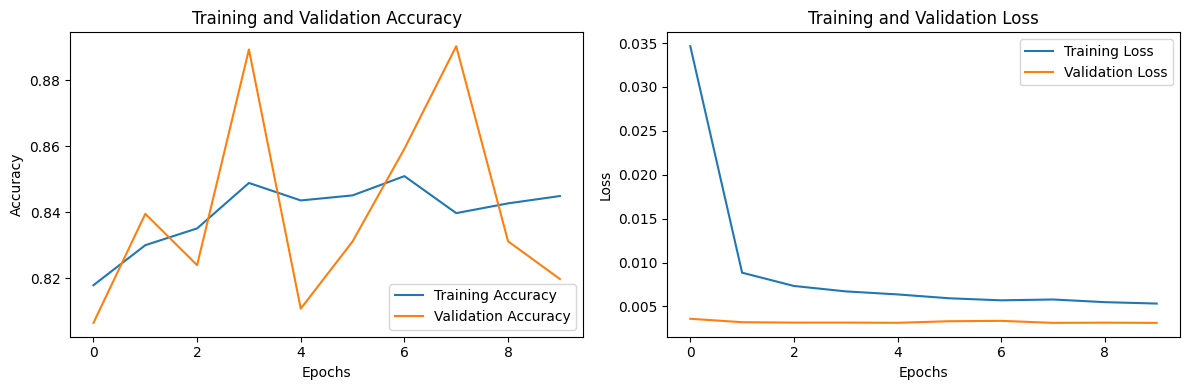

782/782 [==============================] - 2s 2ms/step
Comparing actual and predicted IPC sections:
Actual sections: ('H',)
Predicted sections: ('H',)
----
Actual sections: ('H',)
Predicted sections: ('H',)
----
Actual sections: ('A',)
Predicted sections: ('A',)
----
Actual sections: ('G',)
Predicted sections: ('G',)
----
Actual sections: ('H',)
Predicted sections: ('H',)
----
782/782 [==============================] - 2s 2ms/step - loss: 0.0031 - accuracy: 0.8198
Evaluation metrics: [0.0031213220208883286, 0.8197600245475769]


In [1]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# File paths
train_file_path = 'D:/EPO Dataset/train_dataset.csv'
eval_file_path = 'D:/EPO Dataset/eval_dataset.csv'
model_save_path = 'D:/EPO Dataset/Models/multi_label_ipc_section_model.h5'
checkpoint_dir = 'D:/EPO Dataset/Models/checkpoints'

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to extract IPC sections from multiple IPC codes
def extract_ipc_sections(ipc_code_str):
    return [code.strip()[0] for code in ipc_code_str.split(',')]

# Load the training dataset
train_df = pd.read_csv(train_file_path)
train_df['ipc_section_list'] = train_df['ipc'].apply(extract_ipc_sections)

# Initialize MultiLabelBinarizer for multi-label classification
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['ipc_section_list'])

# Encode the claims using the PatentSBERTa model
model_bert = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')
X_train = model_bert.encode(train_df['claims'].tolist())

# Load the evaluation dataset
eval_df = pd.read_csv(eval_file_path)
eval_df['ipc_section_list'] = eval_df['ipc'].apply(extract_ipc_sections)

# Prepare the evaluation labels
y_test = mlb.transform(eval_df['ipc_section_list'])

# Encode the claims for the evaluation dataset
X_test = model_bert.encode(eval_df['claims'].tolist())

# Define the neural network model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')  # Sigmoid activation for multi-label classification
    ])
    return model

# Compile the model
def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Check if there is a checkpoint to load
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint_path:
    print(f"Resuming from checkpoint: {checkpoint_path}")
    model = create_model()  # Recreate the model architecture
    compile_model(model)  # Compile it before loading weights
    model.load_weights(checkpoint_path)  # Load the weights
else:
    print("No checkpoint found, starting fresh training.")
    model = create_model()
    compile_model(model)

# Define the checkpoint callback to save the model at each epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
    save_weights_only=True,  # Save only the weights
    save_best_only=False,    # Set to True if you only want to save the best model
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback]
)

# Save the final model to the specified path
model.save(model_save_path)
print(f"Final model saved to: {model_save_path}")

# Plot training & validation accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the performance on the evaluation dataset
predictions = model.predict(X_test)

# Convert predictions to multi-label format
predicted_labels = (predictions > 0.5).astype(int)
predicted_sections = mlb.inverse_transform(predicted_labels)

# Convert actual sections to human-readable form
actual_sections = mlb.inverse_transform(y_test)

# Compare predictions with actual IPC sections
print("Comparing actual and predicted IPC sections:")
for i in range(5):  # Display first 5 comparisons
    print(f"Actual sections: {actual_sections[i]}")
    print(f"Predicted sections: {predicted_sections[i]}")
    print("----")

# Evaluate the model performance (accuracy, loss, etc.)
evaluation_metrics = model.evaluate(X_test, y_test)
print(f"Evaluation metrics: {evaluation_metrics}")


In [1]:
import os
import pandas as pd
import tensorflow as tf
from sentence_transformers import SentenceTransformer
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import MultiLabelBinarizer

# File paths
eval_file_path = 'D:/EPO Dataset/eval_dataset.csv'
model_path = 'D:/EPO Dataset/Models/multi_label_ipc_section_model.h5'
output_file_path = 'D:/EPO Dataset/predicted_eval_results.csv'

# Function to extract IPC sections from multiple IPC codes and discard duplicates
def extract_ipc_sections(ipc_codes_str):
    return list(set([code.strip()[0] for code in ipc_codes_str.split(',')]))

# Load the evaluation dataset
if os.path.exists(eval_file_path):
    eval_df = pd.read_csv(eval_file_path)

    # Ensure necessary columns are present
    if {'publication_number', 'ipc', 'claims'}.issubset(eval_df.columns):
        print("Evaluation dataset loaded successfully.")
    else:
        raise ValueError("The required columns are not found in the dataset.")
else:
    raise FileNotFoundError(f"{eval_file_path} not found.")

# Extract IPC sections from the 'ipc' column and discard duplicates
eval_df['ipc_section_list'] = eval_df['ipc'].apply(extract_ipc_sections)

# Load the trained model
model = tf.keras.models.load_model(model_path)
print(f"Model loaded from {model_path}")

# Initialize the SentenceTransformer for claim encoding
model_bert = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Encode the claims
X_test = model_bert.encode(eval_df['claims'].tolist())

# Perform predictions
predictions = model.predict(X_test)

# Initialize MultiLabelBinarizer with fitting based on the unique IPC sections in the evaluation dataset
mlb = MultiLabelBinarizer()
mlb.fit(eval_df['ipc_section_list'])

# Convert predictions to multi-label format
predicted_labels = (predictions > 0.5).astype(int)
predicted_sections = mlb.inverse_transform(predicted_labels)

# Add predicted IPC sections to the dataframe
eval_df['Predicted IPC Sections'] = [", ".join(sections) for sections in predicted_sections]

# Function to compare actual and predicted IPC sections
def compare_ipc_sections(actual, predicted):
    actual_set = set(actual)
    predicted_set = set(predicted)
    matching_sections = actual_set.intersection(predicted_set)
    
    if len(matching_sections) == len(actual_set):
        return "True"
    elif len(matching_sections) == 0:
        return "False"
    elif len(matching_sections) >= len(actual_set) / 2:
        return "True/False"
    else:
        return "False"

# Add the prediction status based on matching IPC sections
eval_df['Prediction Status'] = [
    compare_ipc_sections(actual, predicted) for actual, predicted in zip(eval_df['ipc_section_list'], predicted_sections)
]

# Save the results to a new CSV file
eval_df.to_csv(output_file_path, index=False)
print(f"Results saved to {output_file_path}")

# Count total True, False, and True/False predictions
true_count = (eval_df['Prediction Status'] == 'True').sum()
false_count = (eval_df['Prediction Status'] == 'False').sum()
true_false_count = (eval_df['Prediction Status'] == 'True/False').sum()

# Display the counts
print(f"Total True Predictions: {true_count}")
print(f"Total False Predictions: {false_count}")
print(f"Total True/False Predictions: {true_false_count}")



c:\Users\himal\anaconda3\envs\Aro\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange



Evaluation dataset loaded successfully.

Model loaded from D:/EPO Dataset/Models/multi_label_ipc_section_model.h5
782/782 [==============================] - 2s 2ms/step
Results saved to D:/EPO Dataset/predicted_eval_results.csv
Total True Predictions: 24789
Total False Predictions: 211
Total True/False Predictions: 0


In [3]:
# Display the first three rows in an interactive DataTable
table_widget = widgets.Output()
with table_widget:
    display(eval_df.head(30))  # Display first 3 rows

display(table_widget)

Output()